# Makemore 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
torch_seed = 2147483647

In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(torch_seed) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, W2, b1, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 27.8817
  10000/ 200000: 2.9231
  20000/ 200000: 2.5788
  30000/ 200000: 2.8875
  40000/ 200000: 2.0839
  50000/ 200000: 2.4431
  60000/ 200000: 2.4559
  70000/ 200000: 2.1325
  80000/ 200000: 2.3324
  90000/ 200000: 2.3568
 100000/ 200000: 2.0748
 110000/ 200000: 2.4009
 120000/ 200000: 1.9218
 130000/ 200000: 2.4641
 140000/ 200000: 2.2747
 150000/ 200000: 2.1304
 160000/ 200000: 2.1510
 170000/ 200000: 1.7974
 180000/ 200000: 1.9913
 190000/ 200000: 1.8918


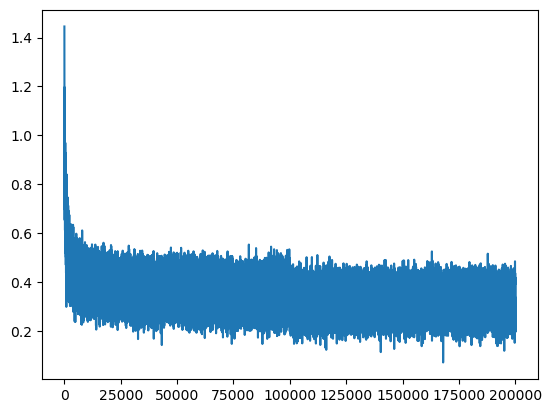

In [9]:
plt.plot(lossi)

In [10]:
@torch.no_grad() # decorator disable gradient tracking'
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concate into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.127152919769287
val 2.173154830932617


In [11]:
split_loss('train')

train 2.127152919769287


In [12]:
# sample from the model
g = torch.Generator().manual_seed(torch_seed)

for _ in range(20):
    out = []
    context = [0] * block_size # initalize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h@ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

dexze.
moglynn.
rochi.
ahnes.
jimmana.
nella.
kama.
aristaithuelthariiotom.
moriella.
kinz.
teda.
kaley.
maside.
enkavion.
roslst.
hani.
gavtahlan.
kashra.
anell.
pynn.


In [13]:
context = [1, 2, 3, 4, 5]
context[1:]

[2, 3, 4, 5]

This completes our trigram model.

This will be the starting point for this notebook. There are multiple things wrong in this model configuration and we'll be fixing them one by one in this notebook.

## Initial loss

The inital loss is 27.8817 and it rapidly comes down to 1 or 2 and this initial loss is really high.

For this problem setup, There's 27 characters that could come next and at initialisation of model the probabality that any of these characters will come next is same which is uniform distribution.

And probabality for each character will be 1/27.0

In [14]:
# Is the intial loss we should get
-torch.tensor(1/27.0).log()

tensor(3.2958)

### Problem

At initialization, the model assigns varaible probablity instead of uniform probabality to all characters which it should. Probabality distributions are all messed up and for some characters it's really confident and for other characters not so much.

To sum up, Model is confidently wrong.

In [15]:
# 4-dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

Logits are uniform, so we get the correct loss. But what if logits varied.

In [16]:
# lucked out at initialisation and we get a really good loss
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

In [17]:
logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02]), tensor(5.0553))

When the logits come out and have random extreme values, we record a high loss.

In [18]:
# with randn
logits = torch.randn(4)
probs = torch.softmax(logits, axis=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-0.3268, -1.2298,  2.2183, -0.9399]),
 tensor([0.0681, 0.0276, 0.8675, 0.0369]),
 tensor(0.1422))

Since the values are near zero loss that comes out is good. but incresing logits by ten fold.

In [19]:
# with randn by tenfold
logits = torch.randn(4) * 10
probs = torch.softmax(logits, axis=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ -3.5451, -18.5060,   9.2707,  -5.9584]),
 tensor([2.7176e-06, 8.6445e-13, 1.0000e+00, 2.4326e-07]),
 tensor(2.9802e-06))

In [20]:
# with randn by hundredfold
logits = torch.randn(4) * 100
probs = torch.softmax(logits, axis=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ 128.8017,  -19.7911, -107.9543,  -23.7986]),
 tensor([1., 0., 0., 0.]),
 tensor(inf))

We get really bad losses for extreme logits.

This is not good and what we want logits to be roughly zero or equal(uniform) at initialisation.

Let's write some code for getting paramters, and training the model since we'll repeat them a lot.

## Helpers

In [21]:
    def model_parameters(block_size, vocab_size, n_embd, n_hidden, seed):
    
        g = torch.Generator().manual_seed(seed)
        C = torch.randn((vocab_size, n_embd), generator=g)
        W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
        b1 = torch.randn(n_hidden, generator=g)
        W2 = torch.randn((n_hidden, vocab_size), generator=g)
        b2 = torch.randn(vocab_size, generator=g)
        return C, W1, b1, W2, b2
            

In [22]:
# Reinit parameters
C, W1, b1, W2, b2 = model_parameters(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_hidden=n_hidden,
    seed=torch_seed
)

# Let's make some changes to params based on above problem descirption
# b2 * 0
# W2 * 0.01
b2 = b2 * 0
W2 = W2 * 0.01

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    # To avoid setting requires_grad multiple times
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

Total number of parameters: 11897


In [23]:
# Run training for first step alone
max_steps = 200000
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(torch_seed)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.3179


Initial loss is now squashed from 27 to 3.3

In [24]:
# Reinit parameters
C, W1, b1, W2, b2 = model_parameters(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_hidden=n_hidden,
    seed=torch_seed
)

b2 = b2 * 0
W2 = W2 * 0.01

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    # To avoid setting requires_grad multiple times
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

# Run full training with updated parameters
max_steps = 200000
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(torch_seed)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

Total number of parameters: 11897
      0/ 200000: 3.3179
  10000/ 200000: 2.1848
  20000/ 200000: 2.3320
  30000/ 200000: 2.4731
  40000/ 200000: 1.9858
  50000/ 200000: 2.4827
  60000/ 200000: 2.1361
  70000/ 200000: 2.1642
  80000/ 200000: 2.3967
  90000/ 200000: 2.0793
 100000/ 200000: 2.4436
 110000/ 200000: 2.1291
 120000/ 200000: 2.2657
 130000/ 200000: 1.7314
 140000/ 200000: 2.1808
 150000/ 200000: 2.2475
 160000/ 200000: 2.0536
 170000/ 200000: 1.6976
 180000/ 200000: 2.4663
 190000/ 200000: 2.2927


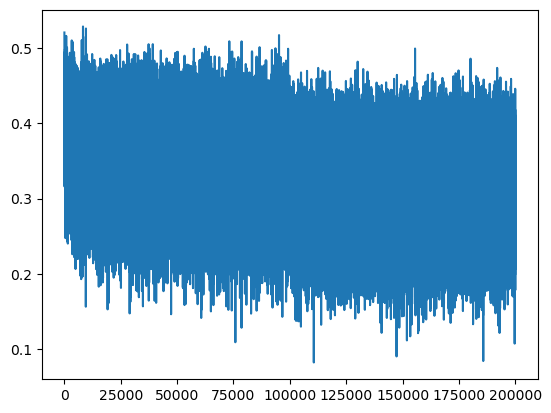

In [25]:
plt.plot(lossi);

We can see in loss plot, the curve bend is squashed after initialising output layer and bias to uniform values.

In [26]:
split_loss('train')
split_loss('val')

train 2.068942070007324
val 2.129626750946045


Train loss has improved from 2.17 to 2.06 because, training has not wasted any time squashing the weights and has looked at the data for additional 10000 steps.

Initialisation has improved initial loss

## Fixing saturated tanh

Logits are now okay, but let's explore h.

#

In [27]:
h

tensor([[-0.9999,  0.5069, -1.0000,  ...,  0.9958, -0.9996,  0.9994],
        [ 0.2820,  0.2718,  0.9532,  ..., -1.0000,  0.9991,  1.0000],
        [-1.0000, -0.9936, -1.0000,  ...,  1.0000, -0.9997, -0.9557],
        ...,
        [ 0.8435, -0.9986, -1.0000,  ...,  1.0000, -0.9982,  1.0000],
        [-1.0000, -0.7951, -0.9999,  ...,  0.9997, -0.9192,  1.0000],
        [-1.0000, -0.9999,  0.0653,  ..., -1.0000,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

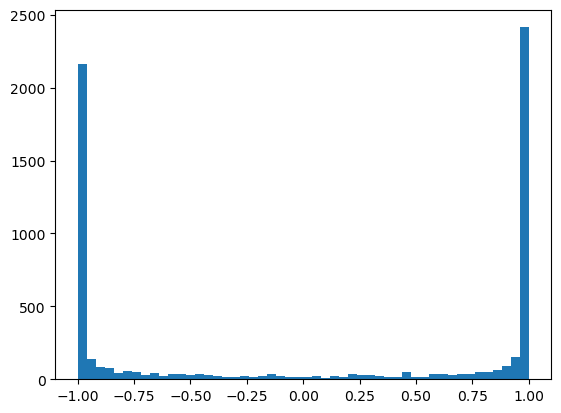

In [28]:
# visualizing h
plt.hist(h.view(-1).tolist(), bins=50);

we can see most of the values take on -1 or 1, meaning tanh is active. And why this happens, let's take a look at pre activations.

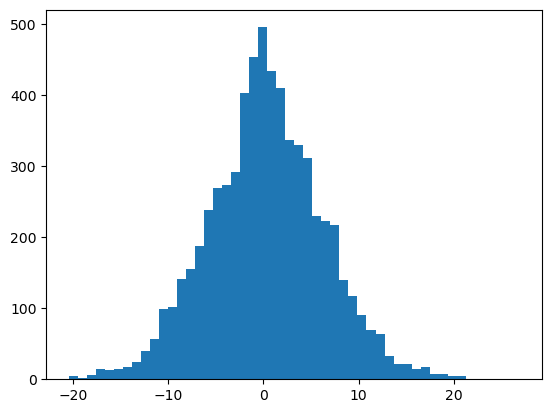

In [29]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

Since preactivations is really broad from -15 to 15 and that's why tanh takes values from -1 to 1.

And why this is a problem. Let's get into the details of it.

During backpropogations the gradients pass through tanh activation.

Grabbing element wise tanh from micrograd,

```Python
def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
```

When t(local gradient) is -1 or 1. self.grad becomes zero because `1 - (-1) ** 2, 1 - (1) ** 2` is `0`.
This is essentialy stopping backpropgation through this neuron beyond tanh.

Intutivley speaking, it tanh's output is close to 1. Changing the input is not going to impact output of tanh, since it's already in flat region of tanh(self.grad = 0). There's no impact on the loss.

So with respect to this input, we cannot impact the loss via backpropgation. The gradient will become zero and vanishes.

In another case, when t = 1 `1 - (0) ** 2` self.grad is out.grad. Meaning tanh unit is inactive and the gradient just passes through.

The gradient flowing through tanh only decreases and the amount it decrease here is proprtional to square (t**2).

> To conclude:
When the tanh output is in flat lands(-1, 1) the gradient vanishes and backpropgation is not effective.

In [30]:
1 - (-1) ** 2, 1 - (1) ** 2

(0, 0)

In [31]:
1 - (0) ** 2

1

Digging deeper into the problem, visualizing 200 tanh neurons across 32 inputs.

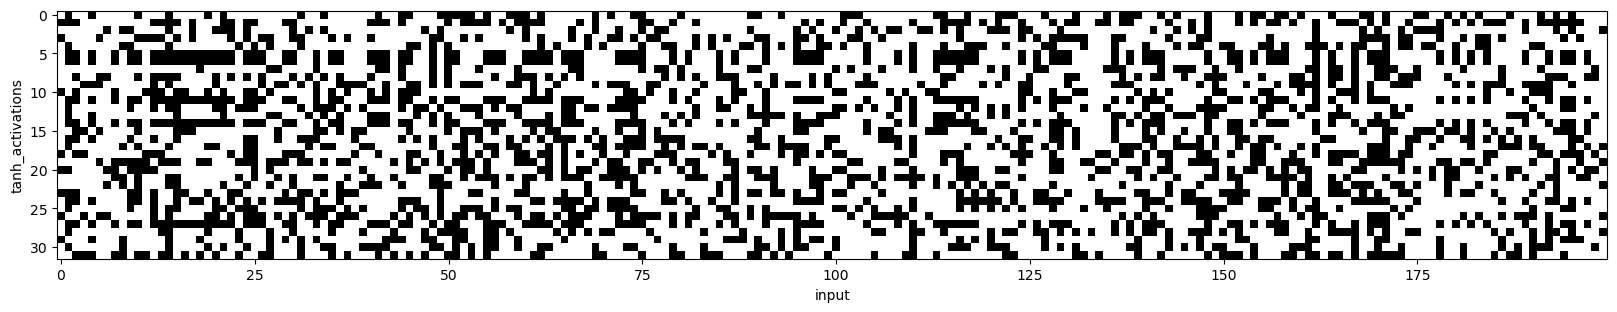

In [32]:
plt.figure(figsize=(20, 10))
plt.xlabel('input')
plt.ylabel('tanh_activations')
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest',);

The plot above is boolean. Thw white dots it plot means tanh is very very active and in flat tail(-1, 1).
In all these cases backward gradient is destroyed.

We'll be in lot of trouble. For any one of these neurons,
If any one of the columns is completley white. In that case this becomes a dead neuron.

The initilisation of w and b is such that, no single input activates this neuron for any input. 
This is a case of dead neuron and it never learns.

This is the problem with saturated tanh(and other activations - sigmoid, relu).

The redeeming quality with this scenario is we don't have any such dead neurons and some gradient's will flow through and neurons will learn.

Another scenario of dead neurons will be during optimization.

Let's say the learning rate is high and the gradient is pushed off to flat tails of tanh or negative tail of relu. The gradients will be zero from that point and will become dead on future backpropgations.

This is called exploding gradients.

Leaky ReLu might not suffer much from thes issues, because of absence of flat parts in it's activation.

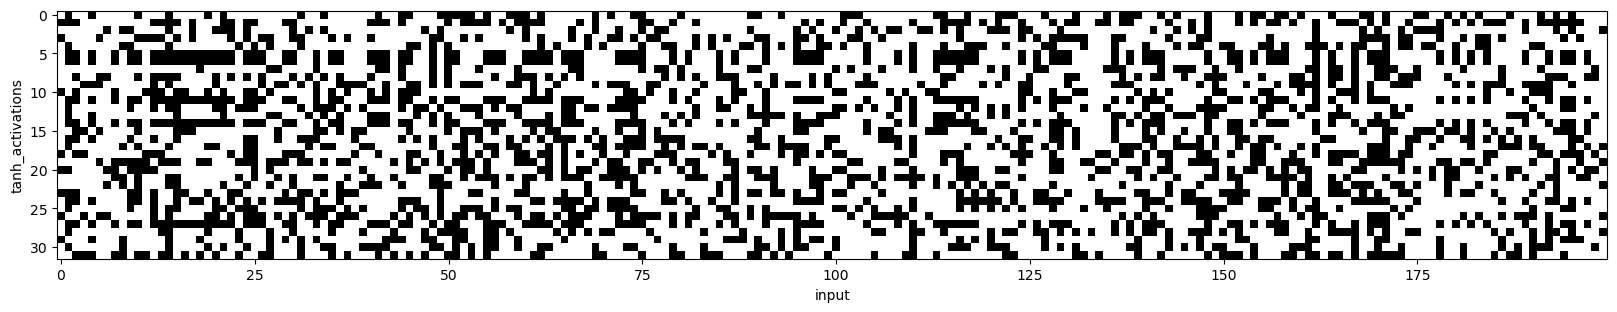

In [33]:
plt.figure(figsize=(20, 10))
plt.xlabel('input')
plt.ylabel('tanh_activations')
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest',);

Going back to h, since we don't have any dead neurons. We should be okay, as the network optimizes and a pretty decent loss.
But this is not optimal and we don't want these extreme value during initialisation. `hpreact` is too extreme, leading to flat tails of tanh activations and less training for these neurons(because they update very less frequent)

embcat -> hpreact(too far from zero which is causing the issue)

We want't hpreact to be closer to 0.

In [34]:
# Reinit weights
C, W1, b1, W2, b2 = model_parameters(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_hidden=n_hidden,
    seed=torch_seed
)

C = C
W1 = W1 * 0.1
b1 = b1 * 0.01
W2 = W2 * 0.01
b2 = b2 * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    # To avoid setting requires_grad multiple times
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

# Rerun first batch
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(torch_seed)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

Total number of parameters: 11897
      0/ 200000: 3.3018


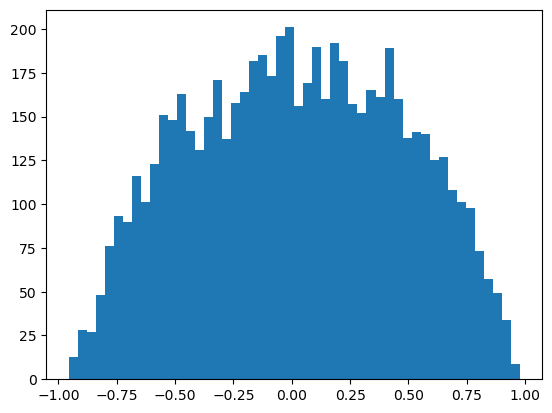

In [35]:
# Let's look at h distribution
plt.hist(h.view(-1).tolist(), bins=50);

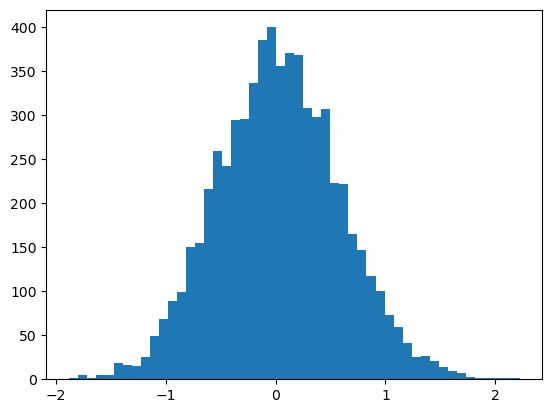

In [36]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

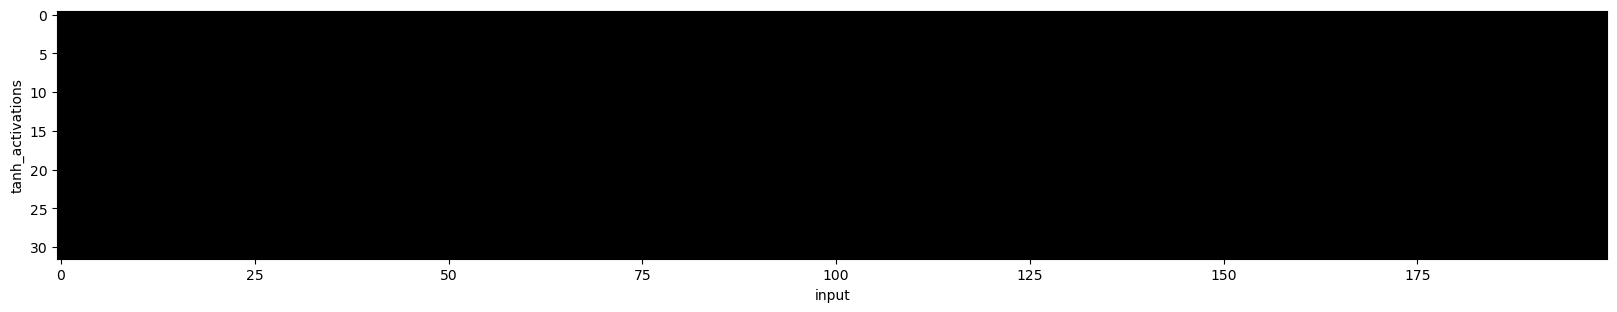

In [37]:
# And this should have less whites
plt.figure(figsize=(20, 10))
plt.xlabel('input')
plt.ylabel('tanh_activations')
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest',);

In [38]:
# Reinit weights
C, W1, b1, W2, b2 = model_parameters(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_hidden=n_hidden,
    seed=torch_seed
)

C = C
W1 = W1 * 0.2
b1 = b1 * 0.01
W2 = W2 * 0.01
b2 = b2 * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    # To avoid setting requires_grad multiple times
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

# Rerun first batch
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(torch_seed)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

Total number of parameters: 11897
      0/ 200000: 3.3070


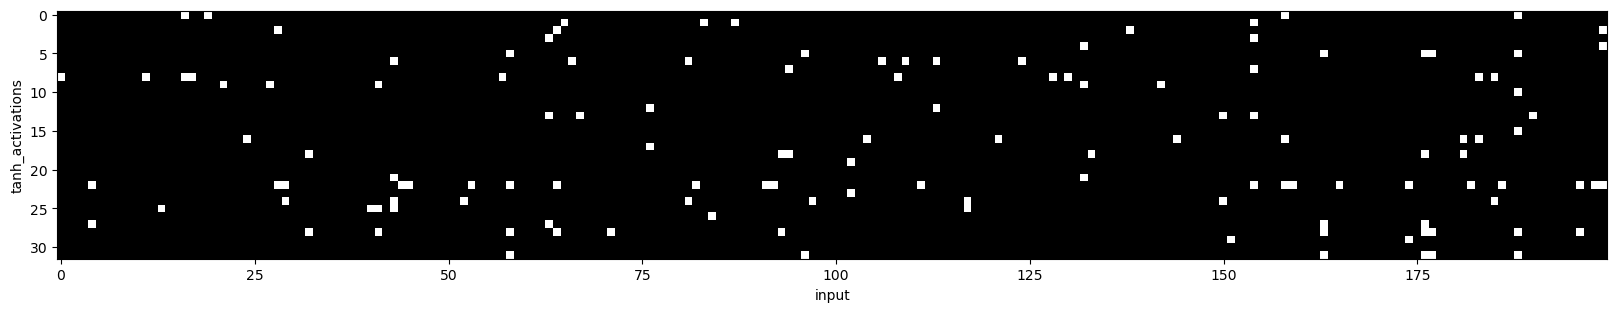

In [39]:
# And this should have less whites
plt.figure(figsize=(20, 10))
plt.xlabel('input')
plt.ylabel('tanh_activations')
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest',);

In [40]:
# Reinit weights
C, W1, b1, W2, b2 = model_parameters(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_hidden=n_hidden,
    seed=torch_seed
)

C = C
W1 = W1 * 0.2
b1 = b1 * 0.01
W2 = W2 * 0.01
b2 = b2 * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    # To avoid setting requires_grad multiple times
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

# Full training
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(torch_seed)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

Total number of parameters: 11897
      0/ 200000: 3.3070
  10000/ 200000: 2.0390
  20000/ 200000: 2.3337
  30000/ 200000: 2.1899
  40000/ 200000: 2.0281
  50000/ 200000: 2.3006
  60000/ 200000: 1.9184
  70000/ 200000: 2.0165
  80000/ 200000: 2.1462
  90000/ 200000: 2.0186
 100000/ 200000: 2.1868
 110000/ 200000: 2.0560
 120000/ 200000: 2.0876
 130000/ 200000: 1.6509
 140000/ 200000: 2.2062
 150000/ 200000: 2.2495
 160000/ 200000: 2.0697
 170000/ 200000: 1.6954
 180000/ 200000: 2.5340
 190000/ 200000: 2.2555


In [41]:
split_loss('train')
split_loss('val')

train 2.036576986312866
val 2.1043293476104736


Losses after initial loss fix

* train 2.068942070007324
* val 2.129626750946045

Losses after tanh saturation fix 

* train 2.036576986312866
* val 2.1043293476104736

The loss is improved because. Network has more time to train and neurons are learning more frequently by avoiding vanishing and exploding gradients.

Since this is a single layer mlp, the initialisation problem was not big issue. But for bigger networks with lots of layers.
These problems will stack up and without proper intilisation the model will not train at all.

How do we come up with these magic number like 0.2 for a larger network with lots of layers.

## Calculating the init scale: "Kaiming init"

tensor(0.0024) tensor(0.9909)
tensor(0.0037) tensor(3.1921)


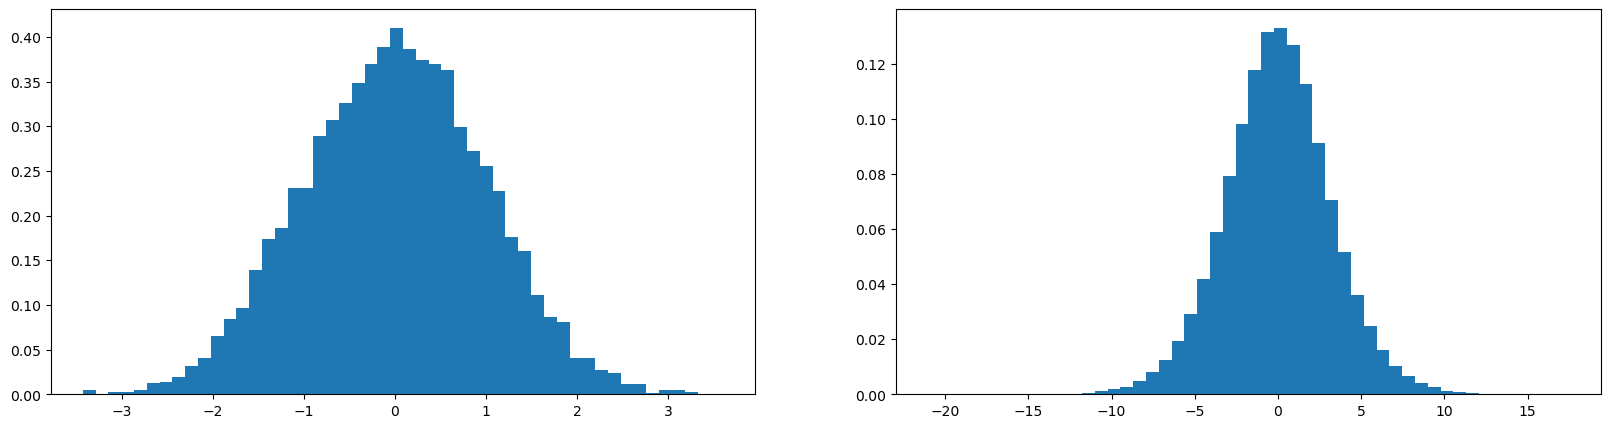

In [42]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

x has zero mean and unit standard deviation, in y, the standard deviation has increased to 3. Meaning gaussian has expanded.
We don't want this in our neural networks, it'll be good if the activations remain the same throught the networks (x->y)

tensor(-0.0097) tensor(0.9965)
tensor(-0.0318) tensor(46.8872)


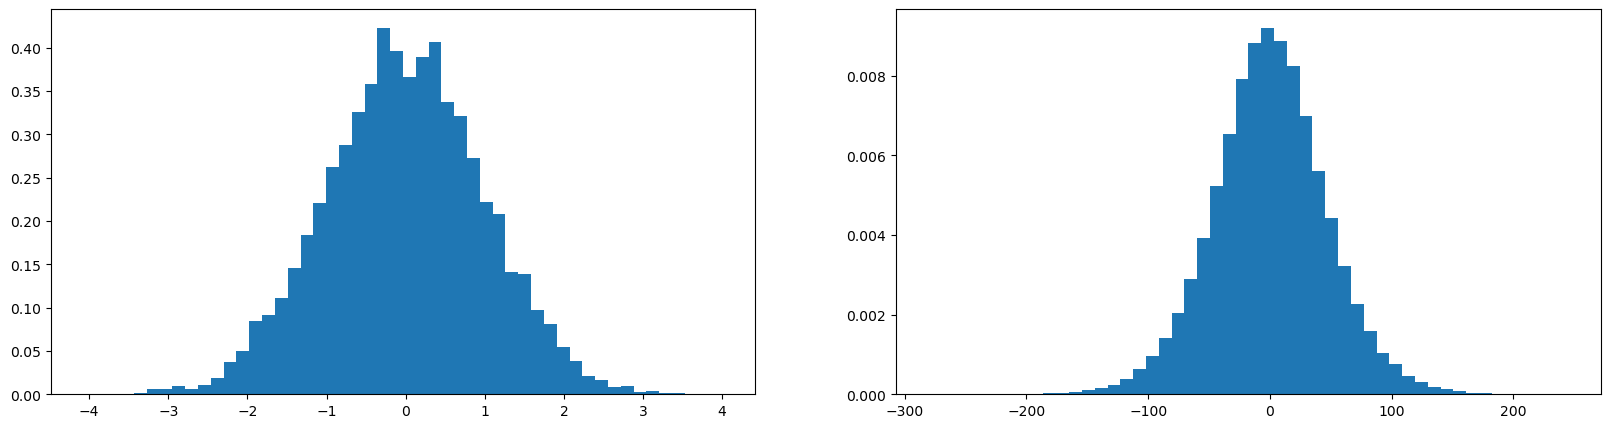

In [43]:
# Let's try to guess the magical number like we did before
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 15
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

The gaussian expands....

tensor(0.0214) tensor(0.9981)
tensor(-0.0003) tensor(0.6492)


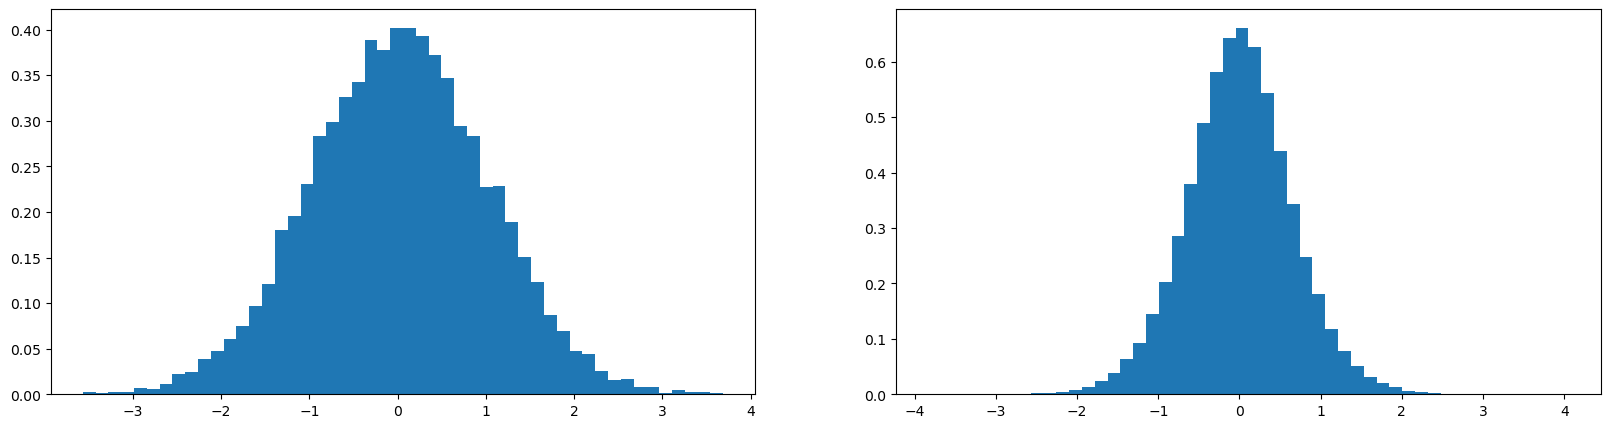

In [44]:
# Let's try to guess the magical number like we did before
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.2
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

The gaussian shrinks....

The correct answer to preserve the standard deviation of 1 mathametically is to divide weights by square root of fan_in(-1 index of w).

tensor(-0.0071) tensor(1.0096)
tensor(0.0010) tensor(1.0265)


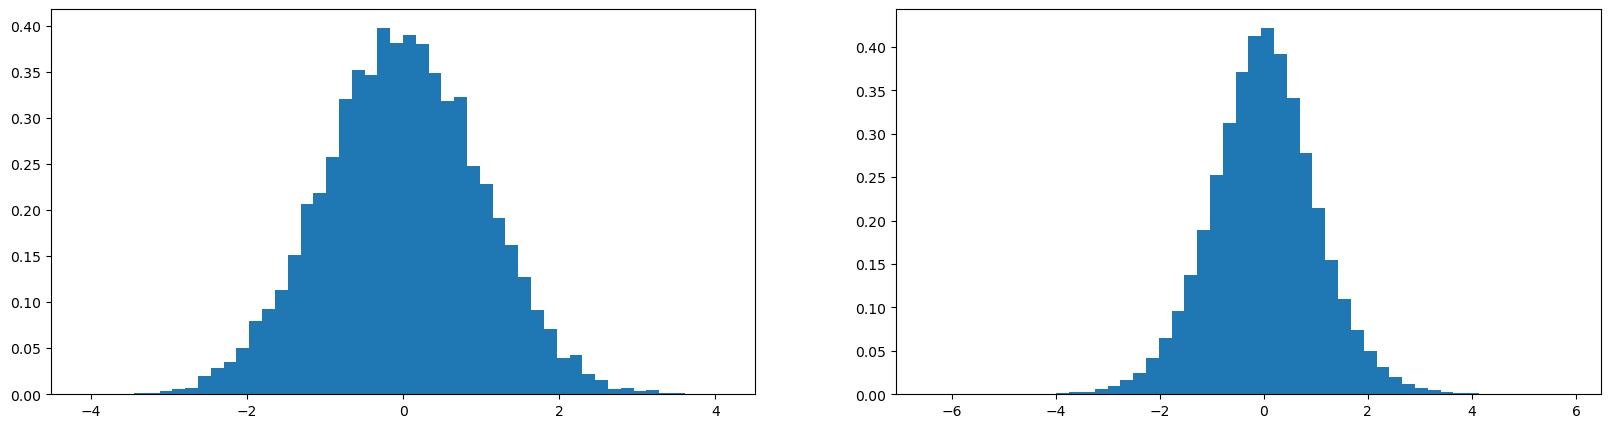

In [45]:
# Square root of fan in
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10 ** 0.5
print(x.mean(), x.std())
y = x @ w
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In case of multi layer perceptrons, there are lot's of layers with different kinds of non-linearities.
We want the activations in such networks to behave without expanding infinitley or shringking to zero.

How do we initialise the rates, so that activations stay good?

[kaiminig he's paper discusses this in detail](https://arxiv.org/pdf/1502.01852v1.pdf)

Few excerpts from the paper.

* In case of relu, 
    * The value is discarded if it's negative, essentially discarding half distribution. 
    * To accodomate this, weights are initialised by square root 2 / fan_in.
    * relu will have zero mean and standard deviation of square root 2 / fan_in.

* If the initialisation is done properly in forward pass, this also takes holds good for backward propogation.

This is also implement in pytorch - [torch.nn.init.kaiming_normal_](https://pytorch.org/docs/stable/nn.init.html)

This might probably be the most commom way of initialising neural networks.

The gain in case of relu 2 and multiplication 1 changes with respect to activation. kaming_normal_ accepts a nonlinearity variable which changes the gain based on the nonlinearity used.

In our case for tanh gain is 5/3.

> **Note:** Reiterating why the gain in addition to initialisation. In case of tanh the values gets squashed between -1 and 1. To go back to the actual distirbution of unit standard deviation we use the gain.

In 2016, without initialisation of weights the networks's wouldn't have learned at all. But now with modern innovations like batch normalization, better optimizers(adam, rmsprop) have overcome this limitaion of initialisation.

In [46]:
# The number we multiply becomes the standard deviation
# incase of randn
(torch.randn(10000) * 0.2).std(), (torch.randn(10000) * 15).std()

(tensor(0.2016), tensor(15.0840))

In [63]:
(5/3) / (W1.shape[0] ** 0.5) # W1.shape[0] = n_embd * n_hidden = fan_in

0.3042903097250923

We've arrived the magical numbe of W! by fiddling with it. But now we've arrived there with concrete explainations behind it.
Now we can scale this to a much deeper network.

In [64]:
# Reinit weights with tanh kamining init
C, W1, b1, W2, b2 = model_parameters(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_hidden=n_hidden,
    seed=torch_seed
)

C = C
W1 = W1 * ((5/3) / (W1.shape[0] ** 0.5))
b1 = b1 * 0.01
W2 = W2 * 0.01
b2 = b2 * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    # To avoid setting requires_grad multiple times
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

# Full training
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(torch_seed)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

Total number of parameters: 11897
      0/ 200000: 3.3097
  10000/ 200000: 2.0894
  20000/ 200000: 2.2969
  30000/ 200000: 2.2137
  40000/ 200000: 2.0346
  50000/ 200000: 2.3579
  60000/ 200000: 1.9309
  70000/ 200000: 2.0086
  80000/ 200000: 2.1751
  90000/ 200000: 1.9542
 100000/ 200000: 2.1990
 110000/ 200000: 2.1659
 120000/ 200000: 2.2354
 130000/ 200000: 1.5944
 140000/ 200000: 2.0789
 150000/ 200000: 2.2208
 160000/ 200000: 2.0440
 170000/ 200000: 1.6595
 180000/ 200000: 2.6510
 190000/ 200000: 2.2066


In [65]:
split_loss('train')
split_loss('val')

train 2.1343231201171875
val 2.201800584793091


Losses after initial loss fix

* train 2.068942070007324
* val 2.129626750946045

Losses after tanh saturation fix 

* train 2.036576986312866
* val 2.1043293476104736

Losses after weights initialisation fix 

* train 2.1343231201171875
* val 2.201800584793091

We've arrived at the same loss but with a more methodical approach which will we can refer for future initialisations.

Let's take a look at one of the modern innovations listed above.

## Batch Normalization

[Batch normalizatio came out in 2015 from google and it made the possiblity of training neural networks reliably](https://arxiv.org/abs/1502.03167).

> Without proper initialisation, the hidden stages(like `hpreact`) might be too small or too large. This will lead to dead neurons(because of vanishing gradient or exploding gradient).
It’s good to maintain gaussian(zero mean unit std) across network to train model properly.

The inference from batch normalization paper -> If what we need is normalization of gaussian in hidden states, why not do that?

Let's standardize/normalize the hidden states.

In [66]:
hpreact.shape

torch.Size([32, 200])

To apply normalization to hidden states and preserve gaussian, We've to subract mean and divide it by standrad deviation of the hidden state itself.

In [77]:
# Reinit weights with tanh kamining init
C, W1, b1, W2, b2 = model_parameters(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_hidden=n_hidden,
    seed=torch_seed
)

C = C
W1 = W1 * ((5/3) / (W1.shape[0] ** 0.5))
b1 = b1 * 0.01
W2 = W2 * 0.01
b2 = b2 * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    # To avoid setting requires_grad multiple times
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

# Full training
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(torch_seed)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  hpreact = hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True)
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

Total number of parameters: 11897
      0/ 200000: 3.3146
  10000/ 200000: 2.0181
  20000/ 200000: 2.3130
  30000/ 200000: 2.1532
  40000/ 200000: 1.8909
  50000/ 200000: 2.3516
  60000/ 200000: 1.9933
  70000/ 200000: 2.0182
  80000/ 200000: 2.2023
  90000/ 200000: 2.1136
 100000/ 200000: 2.3918
 110000/ 200000: 2.0470
 120000/ 200000: 2.1618
 130000/ 200000: 1.6430
 140000/ 200000: 2.1958
 150000/ 200000: 2.2629
 160000/ 200000: 2.0515
 170000/ 200000: 1.6891
 180000/ 200000: 2.4893
 190000/ 200000: 2.1984


In [78]:
@torch.no_grad() # decorator disable gradient tracking'
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True)
    h = torch.tanh(hpreact) # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.041414260864258
val 2.110731363296509


There is repeating pattern n loss here, This is because hidden states is reset everytime not allowing the model to learn. We want the hidden states be roughly gaussian at initialisation and not to be forced to be gaussian all the time.

We would like the neural net to shrink or maximise or make few neurons dead in this distrbution(shringk, maximise, etc happens based on activation).
How do we get this information? - `via backpropogation.

In addition to standardistaion 
```hpreact = hpreact - hpreact.mean(0, keepdim=True) / hpreact.std(0, keepdim=True)```
We'll have a shift(offset) and scale on inputs. We'll scale them by gain and offset them by shift.

In [79]:
# Adding gain of ones and shift of zeros.
# Reinit weights with tanh kamining init
C, W1, b1, W2, b2 = model_parameters(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_hidden=n_hidden,
    seed=torch_seed
)

C = C
W1 = W1 * ((5/3) / (W1.shape[-1] ** 0.5))
b1 = b1 * 0.01
W2 = W2 * 0.01
b2 = b2 * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    # To avoid setting requires_grad multiple times
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

# Full training
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(torch_seed)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

Total number of parameters: 12297
      0/ 200000: 3.3158
  10000/ 200000: 2.0800
  20000/ 200000: 2.3868
  30000/ 200000: 2.1724
  40000/ 200000: 2.0776
  50000/ 200000: 2.3625
  60000/ 200000: 2.0480
  70000/ 200000: 2.0018
  80000/ 200000: 2.3193
  90000/ 200000: 2.0728
 100000/ 200000: 2.1846
 110000/ 200000: 2.0521
 120000/ 200000: 2.2042
 130000/ 200000: 1.7086
 140000/ 200000: 2.1710
 150000/ 200000: 2.2594
 160000/ 200000: 2.1302
 170000/ 200000: 1.7330
 180000/ 200000: 2.5827
 190000/ 200000: 2.3453


bngain is ones and bnbias is zeros at initialisation, effectivley giving us gaussian distribution with zero mean and unit standard deviation irrespective of what comes in hpreact.(roughly what we want at initialisation)

Intution: How we dervied the magical number, bngain mulitpled with inputs meaning inputs has a std of bngain and offset by bnbias meaning input mean of bnbias.

During optimization, bngain and bnbias will be backpropagted and network has full abilites to modify them internally - chaning the gaussian.

In [80]:
@torch.no_grad() # decorator disable gradient tracking'
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact) # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.0610263347625732
val 2.1061418056488037


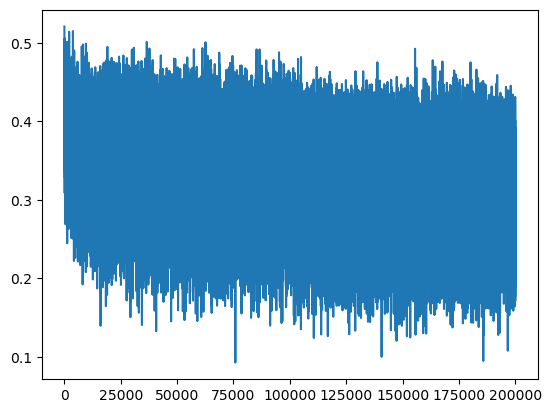

In [71]:
plt.plot(lossi)

Losses after initial loss fix

* train 2.068942070007324
* val 2.129626750946045

Losses after tanh saturation fix 

* train 2.036576986312866
* val 2.1043293476104736

Losses after weights initialisation fix 

* train 2.1343231201171875
* val 2.201800584793091

Losses after batch normalization fix

* train 2.0610263347625732
* val 2.1061418056488037

The loss after batch normalization is similar to some of previous results. This is because we're dealing with really simple neural network with one hidden layer.
The distribution at hpreact maybe already gaussian because of the mathametical intialisation of W1.

But for a deep neural network with lots of layers, it's difficult to find the intialisation value using mathametics considering all activations. This method of initialising weights is not feasible.
In this scenario, just by appending a batch normalization layer after each linear layer. We can stabilize the distribution throughout the network (which is network stabilization itself) and achieve good training.

### Walkthroug of batch norm differences, adv, disadv

There are some changes in neural network because of batch normalization.

At first, one input was passed -> activation -> logits. This was deterministic(which logits belongs to which input).

Next for effeciency, we started processing inputs as inputs and each batch was processed independently.

Now with batch normalization in the batch, the inputs are coupled mathametically in forward and backward pass. Now the hidden state(hpreact) and logits are not just a function of input but all other inputs that came for ride in that batch and these examples are sampled randomnly.

So hpreact changes subtly with respect to the other inputs came in the batch. Since hpreact changes, there'll be a jitter for h and subsequently jitter for logits as well.

This is not a bad thing as a side effect. It kind of act's like a regularizer. We've our h and it's padded out with respect to other inputs in the batch.

This introduces some randomness(entropy) to the neural network, because it auguments the input with respect to other inputs in batch and reducing the chances of overfit on training data.

The side effect augumentation regularizer the neural network for training data.

> Warning⚠️: This mathametical coupling in forward and backward pass for a single input is not desirable as it introduces bugs and gives strange results. Because of this some other techniques like layer normalization, instance normalization came up.

> Summary: Batch normalization was first normalization layer and had regularization efect which stabilized training. Because of regularization effect peopele tried to move on dother normalization techniques. But this worked really well becuase it is quite effective at controlling activations and their distributions.

> Tidbit: Regularization effect of batch normalization is a double edged sword.

### Deployment scenario

Once we're done with training, we'll deploy this in a setting where we pass a single input to get output.

But with batch normalization the networks excepts a input of batch to calculate mean and standard deviation.

Batch normalization paper proopses to calculate batch norm mean and batch norm standara deviation on training set once after training.

#### Calculate bnmean and bnstd for entire training set

In [85]:
# Calibrate the batch norm at the end of training

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure mean/std over entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [86]:
# Update bnmean, bnloss in test time
@torch.no_grad() # decorator disable gradient tracking'
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact) # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.0610263347625732
val 2.1060900688171387


The loss is identitical in test setting, the benefit is we achieve this without passing a batch and a single input.

We don't want to have seperate stage after training to calculate bnmean and bnstd.

The paper proposes to calculate and update running mean during training outside backpropgation.

#### Adding bnmean and bnstd calculation in training.

In [94]:
max_steps = 200000
batch_size = 32
lossi = []

C, W1, b1, W2, b2 = model_parameters(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_hidden=n_hidden,
    seed=torch_seed
)

C = C
W1 = W1 * ((5/3) / (W1.shape[-1] ** 0.5))
b1 = b1 * 0.01
W2 = W2 * 0.01
b2 = b2 * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# Assiging zero mean and unit std
# because initialisation of W1 gives a zero meain unit std gaussian ditribution
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    # To avoid setting requires_grad multiple times
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

# Full training
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(torch_seed)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  
  with torch.no_grad():
    # Nuding running mean and running std slightly with respect to batch mean and batch std
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

Total number of parameters: 12297
      0/ 200000: 3.3158
  10000/ 200000: 2.0800
  20000/ 200000: 2.3868
  30000/ 200000: 2.1724
  40000/ 200000: 2.0776
  50000/ 200000: 2.3625
  60000/ 200000: 2.0480
  70000/ 200000: 2.0018
  80000/ 200000: 2.3193
  90000/ 200000: 2.0728
 100000/ 200000: 2.1846
 110000/ 200000: 2.0521
 120000/ 200000: 2.2042
 130000/ 200000: 1.7086
 140000/ 200000: 2.1710
 150000/ 200000: 2.2594
 160000/ 200000: 2.1302
 170000/ 200000: 1.7330
 180000/ 200000: 2.5827
 190000/ 200000: 2.3453


Now bnstd, bnmea should be near bnmean_running and bnstd_running.

In [95]:
bnmean

tensor([[-1.6862e+00,  2.5819e-01, -2.0339e+00,  1.3228e+00,  8.7459e-01,
          1.1339e+00,  9.9648e-01,  8.6390e-01,  1.2927e-01,  6.7630e-01,
         -1.4872e+00, -1.1275e+00, -3.3669e-01,  5.3425e-01, -7.6715e-01,
          3.3806e-01,  9.0594e-01, -1.9769e+00, -9.4795e-01,  8.4665e-02,
         -3.5957e-02, -8.5726e-01,  7.7996e-01,  1.2519e+00,  2.1238e-01,
          1.1727e+00,  1.4899e+00,  2.2761e-01,  7.4511e-01,  1.5713e+00,
          5.8231e-02, -6.5124e-01, -1.3006e+00, -2.5600e-01,  9.0963e-01,
         -1.8543e-01, -7.4085e-01, -1.7672e-01, -2.0605e-01,  1.8438e-01,
         -7.0214e-01, -3.6324e-01,  6.4814e-01, -5.7135e-01,  6.6818e-01,
         -6.5846e-01,  2.1459e+00, -4.8407e-01,  3.3681e-01,  6.8783e-01,
          1.3092e+00, -2.4661e+00,  2.2820e-01,  1.8144e+00,  8.3149e-01,
         -1.8008e+00, -2.9569e-01, -1.3367e-03,  2.8145e-01, -1.7104e+00,
         -4.1502e-01,  2.1912e-01,  1.6134e+00,  4.0454e-01,  1.2056e+00,
          2.9683e-01,  2.1951e-02,  1.

In [96]:
bnmean_running

tensor([[-1.6807e+00,  2.6440e-01, -2.0426e+00,  1.3272e+00,  8.6582e-01,
          1.1309e+00,  9.8070e-01,  8.6705e-01,  1.2039e-01,  6.6230e-01,
         -1.4832e+00, -1.1298e+00, -3.1863e-01,  5.2248e-01, -7.6075e-01,
          3.5384e-01,  9.0764e-01, -1.9826e+00, -9.5958e-01,  7.7599e-02,
         -3.6109e-02, -8.3590e-01,  7.8474e-01,  1.2454e+00,  2.1839e-01,
          1.1741e+00,  1.4852e+00,  2.2714e-01,  7.4496e-01,  1.5691e+00,
          6.4142e-02, -6.4917e-01, -1.3043e+00, -2.5527e-01,  9.1913e-01,
         -1.8312e-01, -7.3207e-01, -1.8875e-01, -2.0911e-01,  1.8820e-01,
         -7.0145e-01, -3.7654e-01,  6.5075e-01, -5.8726e-01,  6.7461e-01,
         -6.5324e-01,  2.1470e+00, -4.7849e-01,  3.3241e-01,  6.8591e-01,
          1.2959e+00, -2.4643e+00,  2.2941e-01,  1.7964e+00,  8.2476e-01,
         -1.7991e+00, -3.0315e-01, -3.9603e-03,  2.8062e-01, -1.7011e+00,
         -4.1958e-01,  2.1061e-01,  1.6052e+00,  3.9880e-01,  1.2109e+00,
          3.0187e-01,  2.2500e-02,  1.

In [97]:
bnstd

tensor([[2.2843, 1.9237, 2.0461, 2.0205, 1.8500, 2.1933, 1.9701, 2.4522, 1.9835,
         1.8217, 2.4173, 2.0064, 1.8536, 1.7657, 1.7770, 2.1947, 2.0739, 1.9630,
         2.1421, 2.0087, 1.6384, 1.9117, 1.5806, 1.8096, 1.7552, 2.0874, 1.7421,
         2.1437, 2.1504, 2.0433, 1.6857, 1.8339, 1.8224, 1.6137, 1.8212, 1.7351,
         1.7090, 1.5274, 1.9057, 1.7291, 1.8853, 1.8160, 2.1869, 1.4583, 1.6292,
         1.7582, 2.1844, 1.9622, 1.9280, 1.8446, 1.8106, 2.1781, 1.8581, 1.6204,
         1.8955, 1.8551, 1.7168, 1.6878, 1.8961, 1.9690, 1.8301, 1.6934, 1.9103,
         2.4200, 2.1662, 2.1124, 1.8788, 1.9543, 1.8118, 1.9758, 1.8722, 1.7995,
         1.9963, 1.9294, 1.7502, 1.7379, 2.1796, 2.0179, 1.4349, 2.0351, 1.2414,
         2.1808, 1.7088, 1.8171, 2.0794, 2.2421, 1.7146, 2.0418, 2.2659, 2.2996,
         1.6870, 1.9011, 2.2403, 1.8014, 1.5974, 2.1535, 1.7738, 1.5238, 1.7140,
         1.9879, 1.8938, 1.7407, 1.8881, 1.9162, 2.2400, 1.9024, 1.6726, 1.8585,
         1.7542, 1.9229, 1.8

In [98]:
bnstd_running

tensor([[2.2507, 1.8975, 2.0348, 1.9912, 1.8188, 2.1584, 1.9510, 2.4354, 1.9619,
         1.7831, 2.3995, 1.9863, 1.8250, 1.7437, 1.7553, 2.1745, 2.0541, 1.9435,
         2.1247, 1.9861, 1.6254, 1.8826, 1.5634, 1.7869, 1.7428, 2.0675, 1.7219,
         2.1132, 2.1282, 2.0098, 1.6748, 1.8192, 1.8167, 1.5851, 1.8047, 1.7214,
         1.6983, 1.5039, 1.8920, 1.7087, 1.8668, 1.7931, 2.1421, 1.4377, 1.6189,
         1.7332, 2.1486, 1.9348, 1.9113, 1.8257, 1.7880, 2.1486, 1.8332, 1.6078,
         1.8686, 1.8363, 1.7112, 1.6703, 1.8771, 1.9521, 1.8129, 1.6752, 1.8850,
         2.4017, 2.1383, 2.0948, 1.8583, 1.9370, 1.7910, 1.9511, 1.8573, 1.7795,
         1.9740, 1.9042, 1.7365, 1.7189, 2.1626, 1.9859, 1.4146, 2.0160, 1.2314,
         2.1583, 1.6839, 1.7911, 2.0528, 2.2072, 1.6976, 2.0230, 2.2422, 2.2924,
         1.6706, 1.8717, 2.2274, 1.7801, 1.5809, 2.1277, 1.7504, 1.5072, 1.6835,
         1.9623, 1.8687, 1.7243, 1.8634, 1.8820, 2.2235, 1.8803, 1.6578, 1.8265,
         1.7350, 1.8975, 1.8

running mean std are close with mean std calculated after traning.
Now let's set the value

In [99]:
# Update bnmean, bnloss in test time
@torch.no_grad() # decorator disable gradient tracking'
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, vocab_size)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.0608408451080322
val 2.106231451034546


The losses are identical as well.

Few final things to note:

1. while calculating bnstdi, we can have a small epsilon added to it incase when we have zero std. In this network it's not needed as it't not that complex.

2. b1 in `hpreact` is redundant because batch normalization nullifies it by reducting batch mean and adding it has no effect on forward pass and in turn backward pass - meaning no gradients and no impact on model training. We can remove b1 in hpreact and batch normalization has it's own bias `bnbias`

### Batch normalization summary

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

C, W1, b1, W2, b2 = model_parameters(
    block_size=block_size,
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_hidden=n_hidden,
    seed=torch_seed
)

C = C
W1 = W1 * ((5/3) / (W1.shape[-1] ** 0.5))
# b1 = b1 * 0.01
W2 = W2 * 0.01
b2 = b2 * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    # To avoid setting requires_grad multiple times
    p.requires_grad = True
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

# Full training
batch_size = 32
lossi = []
g = torch.Generator().manual_seed(torch_seed)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  # BatchNorm layer
  # ---------------------------------------------------------------------
  with torch.no_grad():
    # Nuding running mean and running std slightly with respect to batch mean and batch std
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # ---------------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

**Summary**:

1. We're using batch normalization to control staisitics of activation in neural nets.
2. It's common to sprinkle them across nets below multiplcation(linear) or convolutional layers
3. It has four parameters,
    * gain and bias calculated with backpropgation
    * mean and std updated outside backpropgation with gain and bias
4. The layer operations,
    * Calculates mean and standard deviation of activations fed to the layer
    * offsets distribution to unit gaussian distribution
    * scales with batch gain and offsets by batch bias
    * Updates running mean and running bias to be used at inference which allows us to forward individual samples to model.